In [1]:
from mushroom import *

c:\Users\Melissa Wang\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support fo

In [2]:
root_folder = "mushrooms"
batch_size = 8

embeds_path = "npy_loads/embeds_all.npy"
gt_labels_path = "npy_loads/ground_truth_labels.npy"
pred_labels_path = "npy_loads/predicted_labels.npy"
species_names_path = "npy_loads/species_names.npy"
image_paths_path = "npy_loads/image_paths.npy"

if all(os.path.exists(p) for p in [embeds_path, gt_labels_path, pred_labels_path, species_names_path, image_paths_path]):
    all_embeds = np.load(embeds_path)
    ground_truth_labels = np.load(gt_labels_path)
    pred_labels = np.load(pred_labels_path)
    species_names = np.load(species_names_path, allow_pickle=True)
    image_paths = np.load(image_paths_path, allow_pickle=True)
    print("All data loaded from saved files.")

All data loaded from saved files.


In [3]:
test_species1 = ['destroying_angel', 'sheathed_woodtuft']
mask = np.isin(ground_truth_labels, test_species1)
subset_embeds1 = all_embeds[mask]
subset_labels1 = ground_truth_labels[mask]

In [4]:
captions_path = "npy_loads/captions.npy"
cleaned_captions_path = "npy_loads/cleaned_captions.npy"
text_embeds_path = "npy_loads/text_embeds.npy"
combined_embeds_path = "npy_loads/combined_embeds.npy"

if os.path.exists(captions_path):
    captions = np.load(captions_path, allow_pickle=True)
    cleaned_captions = np.load(cleaned_captions_path, allow_pickle=True)
    text_embeds = np.load(text_embeds_path)
    combined_embeds = np.load(combined_embeds_path)
    print("All loaded successfully")


All loaded successfully


In [5]:
subset_captions1 = captions[mask]
print(subset_captions1[:3])
print(subset_captions1[-3:])


['a small white mushroom sitting on the ground'
 'a white mushroom sitting on the ground'
 'a close up of a mushroom on the ground']
['a pile of mushrooms sitting on top of a table'
 'a close up of a mushroom on the ground'
 'a bunch of mushrooms sitting on the ground']


In [6]:
sub_image_paths = image_paths[mask]
print(sub_image_paths[:3])

['mushrooms\\destroying_angel\\0.png' 'mushrooms\\destroying_angel\\1.png'
 'mushrooms\\destroying_angel\\10.png']


In [7]:
features_list = classify_mushroom_features_batch(sub_image_paths)

In [8]:
print(features_list[:2])
print(features_list[-2:])
sub_text_embeds = features_to_clip_embeddings(features_list)


[{'cap_shape': 'infundibuliform', 'cap_color': 'white', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'distant', 'gill_size': 'broad'}, {'cap_shape': 'bell-shaped', 'cap_color': 'white', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'distant', 'gill_size': 'broad'}]
[{'cap_shape': 'infundibuliform', 'cap_color': 'tan', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'crowded', 'gill_size': 'broad'}, {'cap_shape': 'infundibuliform', 'cap_color': 'tan', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'crowded', 'gill_size': 'broad'}]


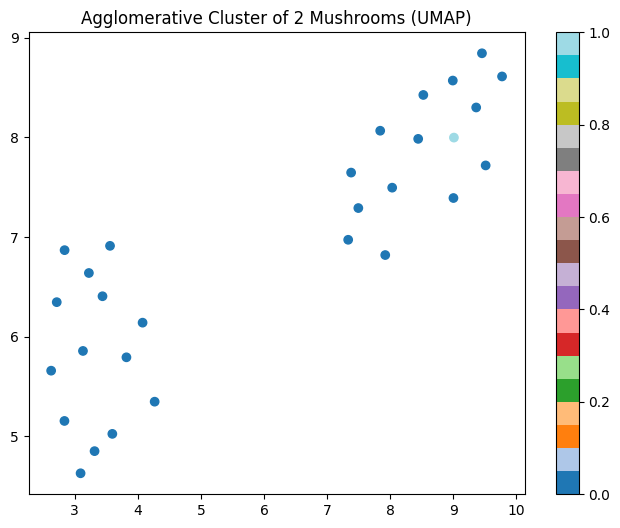

In [9]:
pca_embeds = PCA(n_components=20).fit_transform(subset_embeds1)
sub_agg_labels1, sub_agg_model1 = cluster_agglomerative(pca_embeds, k=2, linkage="average")
umap_embeds = reduce_umap(pca_embeds, n_neighbors=10, min_dist=0.1, n_components=2)
plot_clusters(umap_embeds, sub_agg_labels1, title="Agglomerative Cluster of 2 Mushrooms (UMAP)")

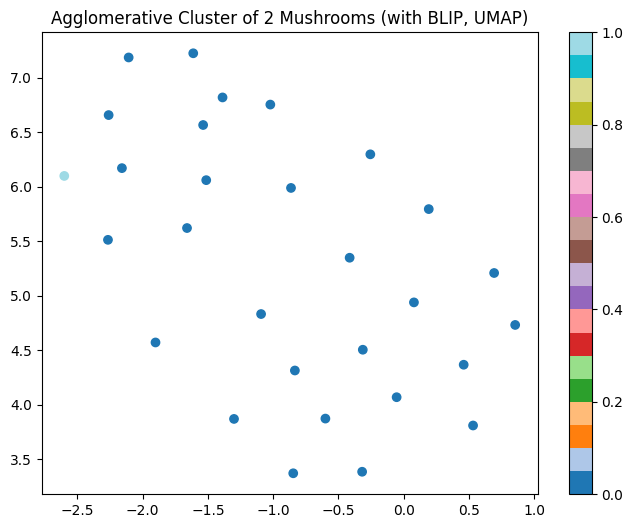

In [10]:
blip_embed = embed_label_prompts(subset_captions1.tolist())
combined_embeds_blip = combine_embeds(subset_embeds1, blip_embed)
pca_embeds2 = PCA(n_components=20).fit_transform(combined_embeds_blip)
sub_agg_labels2, sub_agg_model2 = cluster_agglomerative(pca_embeds2, k=2, linkage="average")
umap_embeds2 = reduce_umap(pca_embeds2, n_neighbors=10, min_dist=0.1, n_components=2)
plot_clusters(umap_embeds2, sub_agg_labels2, title="Agglomerative Cluster of 2 Mushrooms (with BLIP, UMAP)")

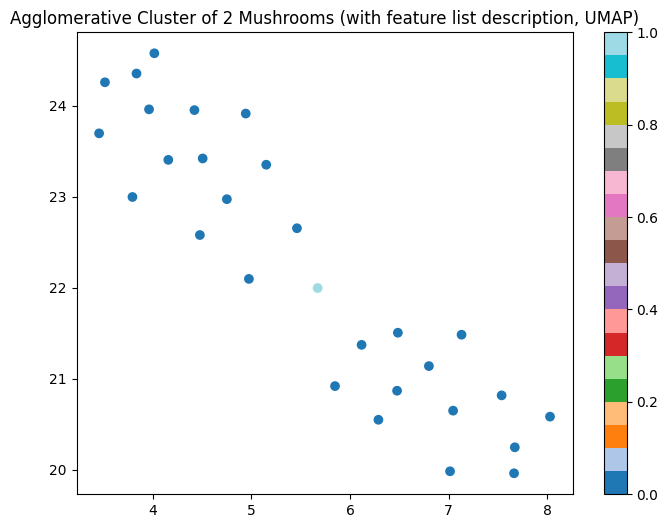

In [11]:
feature_embed = embed_label_prompts(sub_text_embeds)
combined_embeds_ft = combine_embeds(subset_embeds1, feature_embed)

pca_embeds3 = PCA(n_components=20).fit_transform(combined_embeds_ft)
sub_agg_labels3, sub_agg_model3= cluster_agglomerative(pca_embeds3, k=2, linkage="average")
umap_embeds3 = reduce_umap(pca_embeds3, n_neighbors=10, min_dist=0.1, n_components=2)

plot_clusters(umap_embeds3, sub_agg_labels3, title="Agglomerative Cluster of 2 Mushrooms (with feature list description, UMAP)")

Ok now, we try with two similar mushrooms + some feature embedding. Eg. Field Mushroom and Deathcap. One's dangerous and one's not, but they both have similar features too. 

In [12]:
test_species2 = ['field_mushroom', 'deathcap']
mask2 = np.isin(ground_truth_labels, test_species2)
subset_embeds2 = all_embeds[mask2]
subset_labels2 = ground_truth_labels[mask2]

In [13]:
sub_image_paths2 = image_paths[mask2]
features_list2 = classify_mushroom_features_batch(sub_image_paths2)
sub_text_embeds2 = features_to_clip_embeddings(features_list2)
print(features_list2[:2])
print(features_list2[-2:])

[{'cap_shape': 'bell-shaped', 'cap_color': 'brown', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'crowded', 'gill_size': 'broad'}, {'cap_shape': 'infundibuliform', 'cap_color': 'white', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'close', 'gill_size': 'broad'}]
[{'cap_shape': 'infundibuliform', 'cap_color': 'brown', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'crowded', 'gill_size': 'broad'}, {'cap_shape': 'infundibuliform', 'cap_color': 'white', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'glandular', 'gill_spacing': 'crowded', 'gill_size': 'broad'}]


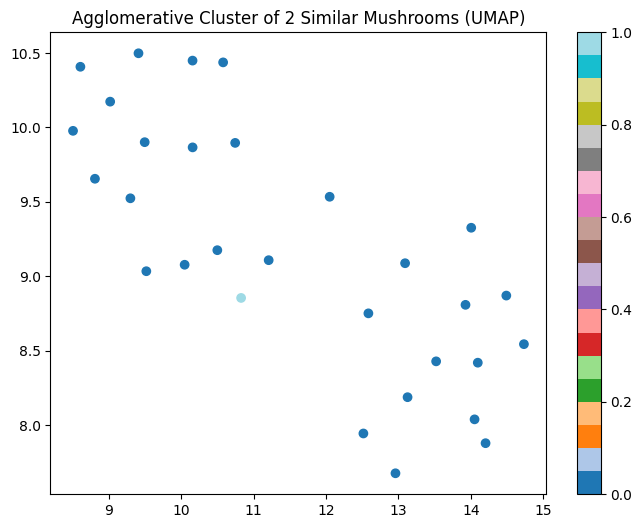

In [14]:
pca_embeds4 = PCA(n_components=20).fit_transform(subset_embeds2)
sub_agg_labels4, sub_agg_model4= cluster_agglomerative(pca_embeds4, k=2, linkage="average")
umap_embeds4 = reduce_umap(pca_embeds4, n_neighbors=10, min_dist=0.1, n_components=2)
plot_clusters(umap_embeds4, sub_agg_labels4, title="Agglomerative Cluster of 2 Similar Mushrooms (UMAP)")



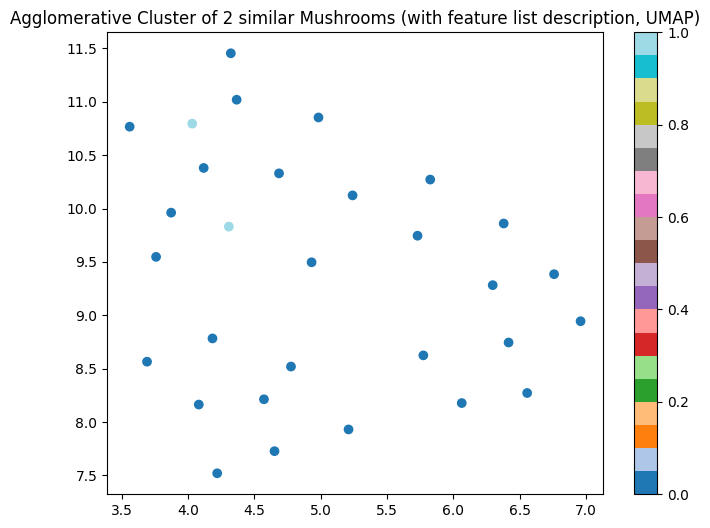

In [15]:
feature_embed2 = embed_label_prompts(sub_text_embeds2)
combined_embeds_ft2 = combine_embeds(subset_embeds2, feature_embed2)

pca_embeds5 = PCA(n_components=20).fit_transform(combined_embeds_ft2)
sub_agg_labels5, sub_agg_model5= cluster_agglomerative(pca_embeds5, k=2, linkage="average")
umap_embeds5 = reduce_umap(pca_embeds5, n_neighbors=10, min_dist=0.1, n_components=2)

plot_clusters(umap_embeds5, sub_agg_labels5, title="Agglomerative Cluster of 2 similar Mushrooms (with feature list description, UMAP)")
